In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pylab as plt
from scipy import ndimage
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import AdamW

2022-06-22 21:28:51.527639: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images


def compute_gradients(images, target_class_idx, model):
  with tf.GradientTape() as tape:
    tape.watch(images)
    #logits = model(images, training=False)
    #probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    probs = model(images, training=False)[:, target_class_idx]
  return tape.gradient(probs, images)


def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients


@tf.function # compile the function into a high performance callable TensorFlow graph
def integrated_gradients(baseline,
                         image,
                         model,
                         target_class_idx,
                         m_steps=50,
                         batch_size=8):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(model=model,
                                       images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
    
  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [226]:
image_size = (288+512, 288+512)
model = tf.keras.models.load_model('best_models/512x512/oversample_model_f1_095.h5', custom_objects={'AdamW': tfa.optimizers.AdamW})

# image_size = (64+128, 64+128)
# model = tf.keras.models.load_model('best_models/128x128/oversample_model_f1_085.h5', custom_objects={'AdamW': tfa.optimizers.AdamW})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
Augment_and_Crop_and_Rescale (S (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         Augment_and_Crop_and_Rescale[0][0
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
______________________________________________________________________________________________

In [227]:
##### Model on smaller img res ####

# False Negatives
# img_name = "cb7c73_20200515T113021_20200515T113126_mos_rgb.png"
# img_name = "e4ecea_20200803T112425_20200803T112540_mos_rgb.png"
# img_name = "ec02c1_20171216T103356_20171216T103555_mos_rgb.png"
# img_name = "ec0d39_20181229T080453_20181229T080621_mos_rgb.png"
# img_name = "ecc879_20201204T041136_20201204T041341_mos_rgb.png"
# img_name = "f3e78b_20181103T184809_20181103T184924_mos_rgb.png"
# img_name = "f3f01c_20201223T070828_20201223T070926_mos_rgb.png"
# img_name = "f8dba3_20180117T143557_20180117T143801_mos_rgb.png"
# img_name = "ff3721_20171228T085625_20171228T085714_mos_rgb.png"

# False Positives
img_name = "cca544_20150915T062552_20150915T062756_mos_rgb.png"
# img_name = "cca544_20151009T062553_20151009T062757_mos_rgb.png"
# img_name = "d47404_20180927T162737_20180927T162852_mos_rgb.png"
# img_name = "d9d7e0_20200114T181051_20200114T181251_mos_rgb.png"
# img_name = "e51fe1_20190506T043022_20190506T043142_mos_rgb.png"

In [228]:
# Load image to test
# path = "/home/filippo/data/polar_low/results/FP/"
# path = "/home/filippo/data/polar_low/test/pos/"
path = "/home/filippo/data/polar_low/test/neg/"


# False Positives
# img_name = "dfc02d_20180915T185746_20180915T185926_mos_rgb.png"
# img_name = "cffe42_20191024T084042_20191024T084201_mos_rgb.png"
# img_name = "e7bd09_20180206T063916_20180206T064216_mos_rgb.png"
# img_name = "f850aa_20160219T085536_20160219T085716_mos_rgb.png"
# img_name = "ff3721_20180109T085625_20180109T085714_mos_rgb.png"

# True positives
# img_name = "cac66d_20190731T034721_20190731T034910_mos_rgb.png"
# img_name = "cb7c73_20200515T113021_20200515T113126_mos_rgb.png"
# img_name = "cffe42_20191012T084028_20191012T084212_mos_rgb.png"
# img_name = "d1996d_20200406T190715_20200406T190819_mos_rgb.png"
# img_name = "f06932_20151211T163926_20151211T164030_mos_rgb.png"
# img_name = "f414c2_20181226T055833_20181226T060006_mos_rgb.png"


img = keras.preprocessing.image.load_img(
    path + img_name, 
    target_size=image_size
)

data_augmentation = keras.Sequential(
    [
#         keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='constant'),
#         keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#         keras.layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant'),
#         keras.layers.experimental.preprocessing.RandomZoom((-0.1,0.1), fill_mode='constant'),
    ]
)
img = data_augmentation(np.expand_dims(img,0))[0]

# plt.imshow(img[144:-144,144:-144])
# plt.show()

img_array = keras.preprocessing.image.img_to_array(img)

pred = model.predict(tf.expand_dims(img_array, 0))
print(pred)

[[0.9720139  0.02798608]]


In [229]:
baseline = tf.zeros(shape=image_size +(3,))

baseline_pred = model.predict(tf.expand_dims(baseline, 0))
print("baseline_pred:", baseline_pred)

# Since the model has Dropout and image augmentation layers, we need to disable it to compute the gradients
# tf.keras.backend.set_learning_phase(0)

igrads = integrated_gradients(baseline=baseline,
                              image=img_array,
                              model=model,
                              target_class_idx=1,
                              m_steps=200,
                              batch_size=4)

baseline_pred: [[9.999951e-01 4.927958e-06]]


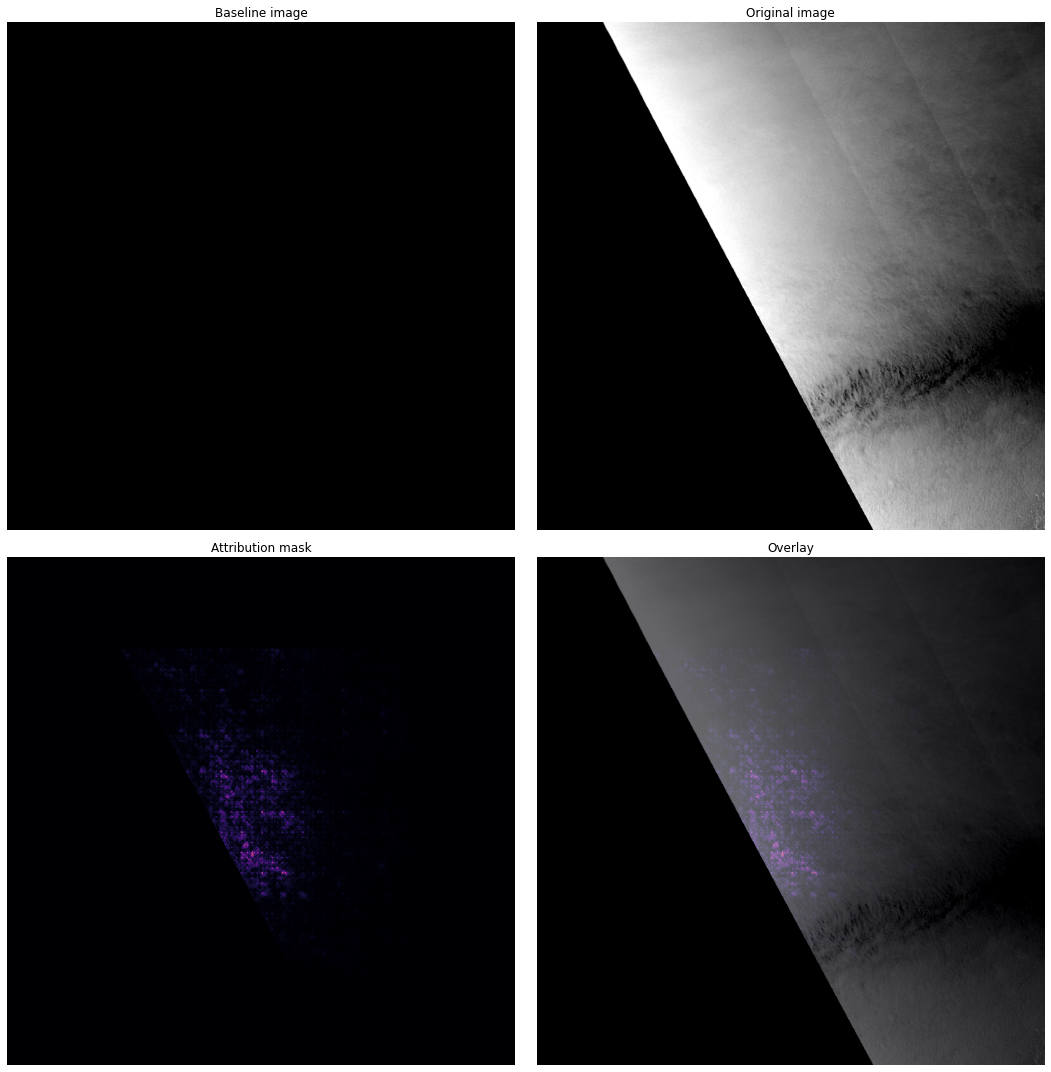

In [230]:
def plot_img_attributions(baseline,
                          image,
                          integrated_gradients,
                          cmap=None,
                          overlay_alpha=0.4):

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(integrated_gradients), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(15, 15))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig


_ = plot_img_attributions(image=img_array.astype(np.uint8),
                          baseline=baseline,
                          integrated_gradients=igrads,
                          cmap=plt.cm.magma,
                          overlay_alpha=0.4)

In [231]:
class GradVisualizer:
    """Plot gradients of the outputs w.r.t an input image."""

    def __init__(self, positive_channel=None, negative_channel=None):
        if positive_channel is None:
            self.positive_channel = [0, 255, 0]
        else:
            self.positive_channel = positive_channel

        if negative_channel is None:
            self.negative_channel = [255, 0, 0]
        else:
            self.negative_channel = negative_channel

    def apply_polarity(self, attributions, polarity):
        if polarity == "positive":
            return np.clip(attributions, 0, 1)
        else:
            return np.clip(attributions, -1, 0)

    def apply_linear_transformation(
        self,
        attributions,
        clip_above_percentile=99.9,
        clip_below_percentile=70.0,
        lower_end=0.2,
    ):
        # 1. Get the thresholds
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        # 2. Transform the attributions by a linear function f(x) = a*x + b such that
        # f(m) = 1.0 and f(e) = lower_end
        transformed_attributions = (1 - lower_end) * (np.abs(attributions) - e) / (
            m - e
        ) + lower_end

        # 3. Make sure that the sign of transformed attributions is the same as original attributions
        transformed_attributions *= np.sign(attributions)

        # 4. Only keep values that are bigger than the lower_end
        transformed_attributions *= transformed_attributions >= lower_end

        # 5. Clip values and return
        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        # 1. Flatten the attributions
        flatten_attr = attributions.flatten()

        # 2. Get the sum of the attributions
        total = np.sum(flatten_attr)

        # 3. Sort the attributions from largest to smallest.
        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        # 4. Calculate the percentage of the total sum that each attribution
        # and the values about it contribute.
        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        # 5. Threshold the attributions by the percentage
        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        # 6. Select the desired attributions and return
        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def binarize(self, attributions, threshold=0.001):
        return attributions > threshold

    def morphological_cleanup_fn(self, attributions, structure=np.ones((4, 4))):
        closed = ndimage.grey_closing(attributions, structure=structure)
        opened = ndimage.grey_opening(closed, structure=structure)
        return opened

    def draw_outlines(
        self, attributions, percentage=90, connected_component_structure=np.ones((3, 3))
    ):
        # 1. Binarize the attributions.
        attributions = self.binarize(attributions)

        # 2. Fill the gaps
        attributions = ndimage.binary_fill_holes(attributions)

        # 3. Compute connected components
        connected_components, num_comp = ndimage.measurements.label(
            attributions, structure=connected_component_structure
        )

        # 4. Sum up the attributions for each component
        total = np.sum(attributions[connected_components > 0])
        component_sums = []
        for comp in range(1, num_comp + 1):
            mask = connected_components == comp
            component_sum = np.sum(attributions[mask])
            component_sums.append((component_sum, mask))

        # 5. Compute the percentage of top components to keep
        sorted_sums_and_masks = sorted(component_sums, key=lambda x: x[0], reverse=True)
        sorted_sums = list(zip(*sorted_sums_and_masks))[0]
        cumulative_sorted_sums = np.cumsum(sorted_sums)
        cutoff_threshold = percentage * total / 100
        cutoff_idx = np.where(cumulative_sorted_sums >= cutoff_threshold)[0][0]
        if cutoff_idx > 2:
            cutoff_idx = 2

        # 6. Set the values for the kept components
        border_mask = np.zeros_like(attributions)
        for i in range(cutoff_idx + 1):
            border_mask[sorted_sums_and_masks[i][1]] = 1

        # 7. Make the mask hollow and show only the border
        eroded_mask = ndimage.binary_erosion(border_mask, iterations=1)
        border_mask[eroded_mask] = 0

        # 8. Return the outlined mask
        return border_mask

    def process_grads(
        self,
        image,
        attributions,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
    ):
        if polarity not in ["positive", "negative"]:
            raise ValueError(
                f""" Allowed polarity values: 'positive' or 'negative'
                                    but provided {polarity}"""
            )
        if clip_above_percentile < 0 or clip_above_percentile > 100:
            raise ValueError("clip_above_percentile must be in [0, 100]")

        if clip_below_percentile < 0 or clip_below_percentile > 100:
            raise ValueError("clip_below_percentile must be in [0, 100]")

        # 1. Apply polarity
        if polarity == "positive":
            attributions = self.apply_polarity(attributions, polarity=polarity)
            channel = self.positive_channel
        else:
            attributions = self.apply_polarity(attributions, polarity=polarity)
            attributions = np.abs(attributions)
            channel = self.negative_channel

        # 2. Take average over the channels
        attributions = np.average(attributions, axis=2)

        # 3. Apply linear transformation to the attributions
        attributions = self.apply_linear_transformation(
            attributions,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            lower_end=0.0,
        )

        # 4. Cleanup
        if morphological_cleanup:
            attributions = self.morphological_cleanup_fn(
                attributions, structure=structure
            )
        # 5. Draw the outlines
        if outlines:
            attributions = self.draw_outlines(
                attributions, percentage=outlines_component_percentage
            )

        # 6. Expand the channel axis and convert to RGB
        attributions = np.expand_dims(attributions, 2) * channel

        # 7.Superimpose on the original image
        if overlay:
            attributions = np.clip((attributions + image * 0.5), 0, 255)
        return attributions

    def visualize(
        self,
        image,
        integrated_gradients,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
        figsize=(15, 8),
    ):
        # Make a copy of the original image
        img1 = np.copy(image)

        # Process the integrated gradients
        igrads_attr = self.process_grads(
            image=img1,
            attributions=integrated_gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

#         _, ax = plt.subplots(1, 2, figsize=figsize)
#         ax[0].imshow(image.astype(np.uint8))
#         ax[0].axis("off")
#         ax[1].imshow(igrads_attr.astype(np.uint8))
#         ax[1].axis("off")

        _, ax = plt.subplots(1, 1, figsize=figsize)
        ax.imshow(image.astype(np.uint8))
        ax.axis("off")

        _, ax = plt.subplots(1, 1, figsize=figsize)
        ax.imshow(igrads_attr.astype(np.uint8))
        ax.axis("off")
        

#         ax[0].set_title("Input")
#         ax[1].set_title("Integrated gradients")
        plt.show()

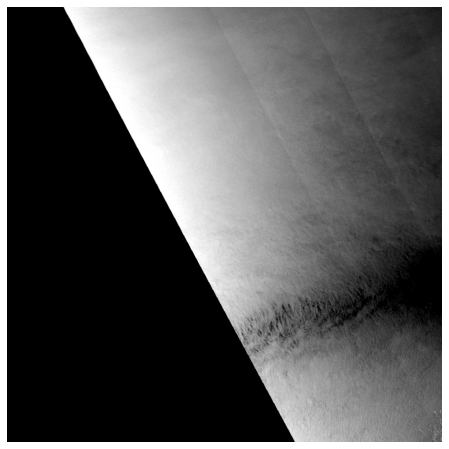

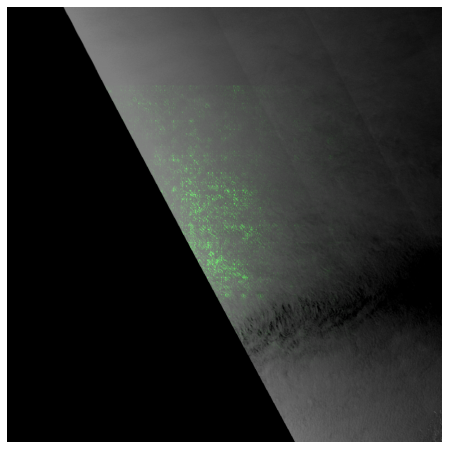

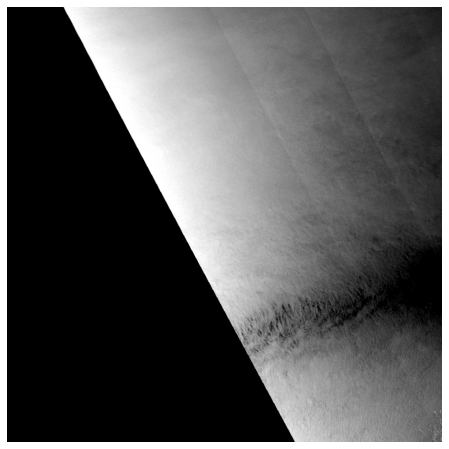

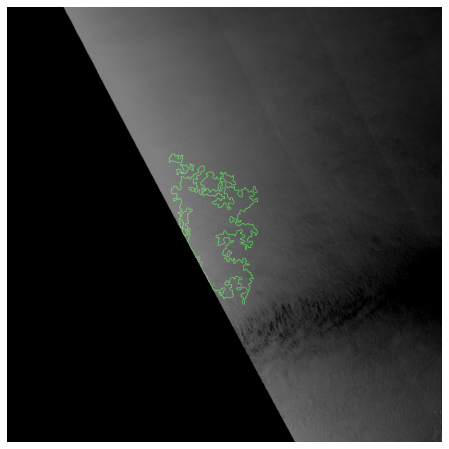

In [232]:
vis = GradVisualizer()
vis.visualize(
    image=img_array,
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=0,
    figsize=(8, 8)
)

vis.visualize(
    image=img_array,
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=45,
    morphological_cleanup=True,
    outlines=True,
)